<a href="https://colab.research.google.com/github/PratyushNag/Music-Generator-v1/blob/main/Music_Generation_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collecting Data

In [ ]:
from google.colab import files
! pip install -q kaggle
#upload kaggle.json
files.upload()

In [4]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d imsparsh/lakh-midi-clean
#!kaggle datasets download -d soumikrakshit/classical-music-midi

In [ ]:
! mkdir Midi
! unzip lakh-midi-clean.zip -d Midi
#! unzip classical-music-midi.zip -d Midi_classical

# Installing dependencies and imports

In [7]:
!sudo apt install -y fluidsynth

Processing triggers for man-db (2.10.2-1) ...


In [8]:
!pip install --upgrade pyfluidsynth

In [9]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 6.5 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592284 sha256=e619f136b4e5b5a1b6811a98eeadd571f5416d1d315ca70dc998e149130e1542
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi


In [10]:
!pip install display

  Preparing metadata (setup.py) ... done
  Created wheel for display: filename=display-1.0.0-py3-none-any.whl size=1380 sha256=55d276b5aaf72c38450693bc0785a42784f09064fcd0a9505cab21ba3234017f
  Stored in directory: /root/.cache/pip/wheels/c8/03/f5/a10e442f4903dd16b0e7914afe0f24392305535fd6f9cef522
Successfully built display


In [11]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
import pretty_midi
import fluidsynth
from IPython.display import display, Audio
import collections
from typing import Optional
import tensorflow as tf
import keras
from keras.datasets import imdb
from keras.layers import Dense, LSTM, Dropout, MaxPooling1D, Flatten, AveragePooling1D, AveragePooling2D, MaxPooling2D, Bidirectional
from keras.losses import BinaryCrossentropy
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences

In [12]:
#setting seed for randomness
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

# Data Munging

Mapping the data onto a dataframe for easy viewing acess

In [13]:
paths = []
for dirname, _, filenames in os.walk('Midi'):
    for filename in filenames:
        if filename.lower().endswith(".mid"):
            paths.append(os.path.join(dirname, filename))

In [14]:
midi_df = pd.DataFrame()
midi_df['midi'] = paths
midi_df.head()

,midi
0,Midi/Grace_Jones/Slave_to_the_Rhythm.mid
1,Midi/The_Buckinghams/Kind_of_a_Drag.1.mid
2,Midi/The_Buckinghams/Kind_of_a_Drag.mid
3,Midi/The_Buckinghams/Hey_Baby_Theyre_Playing_O...
4,"Midi/The_Buckinghams/Mercy,_Mercy,_Mercy.mid"


In [15]:
midi_df.shape

(17232, 1)

In [16]:
#converting a sample MIDI file into a playable file using the pretty midi library
pm = pretty_midi.PrettyMIDI(midi_df.loc[3, 'midi'])

In [17]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    waveform_short = waveform[:seconds*_SAMPLING_RATE]
    return display(Audio(waveform_short, rate=_SAMPLING_RATE))

In [18]:
display_audio(pm)

In [133]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 17
Instrument name: Electric Piano 2


In [21]:
# function to convert MIDI file into it's specific notes, so its easier for user to view
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    try:
        pm = pretty_midi.PrettyMIDI(midi_file)
        instrument = pm.instruments[0]
        notes = collections.defaultdict(list)

        # Sort the notes by start time
        sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
        prev_start = sorted_notes[0].start
        #Here we split the data into three respective features
        #pitch = note pressed (represented in numerical format)
        #step = when the note is pressed, w.r.t the last note
        #duration = how long the note is pressed for
        for note in sorted_notes:
            start = note.start
            end = note.end
            notes['pitch'].append(note.pitch)
            notes['start'].append(start)
            notes['end'].append(end)
            notes['step'].append(start - prev_start)
            notes['duration'].append(end - start)
            prev_start = start

        return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

    except Exception as e:
        print(f"Error processing file {midi_file}: {str(e)}")
        return None

In [22]:
raw_notes = midi_to_notes(midi_df.loc[3, 'midi'])
raw_notes.head()

,pitch,start,end,step,duration
0,36,3.214275,3.446417,0.000000,0.232142
1,41,3.428560,4.928555,0.214285,1.499995
2,53,3.642845,3.999987,0.214285,0.357142
3,57,3.857130,3.999987,0.214285,0.142857
4,60,3.857130,3.999987,0.000000,0.142857


In [23]:
#adding a column 'note' converting respective pitches into understandable music notes
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
raw_notes['note'] = get_note_names(raw_notes['pitch'])
raw_notes

,pitch,start,end,step,duration,note
0,36,3.214275,3.446417,0.000000,0.232142,C2
1,41,3.428560,4.928555,0.214285,1.499995,F2
2,53,3.642845,3.999987,0.214285,0.357142,F3
3,57,3.857130,3.999987,0.214285,0.142857,A3
4,60,3.857130,3.999987,0.000000,0.142857,C4
...,...,...,...,...,...,...
809,41,149.785215,150.035214,0.000000,0.249999,F2
810,62,150.213785,150.374499,0.428570,0.160714,D4
811,58,150.213785,150.374499,0.000000,0.160714,A#3
812,53,150.213785,150.374499,0.000000,0.160714,F3


## Visualising the given data

In [24]:
#function to plot a piano roll graph from the given MIDI file for visualization purposes
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

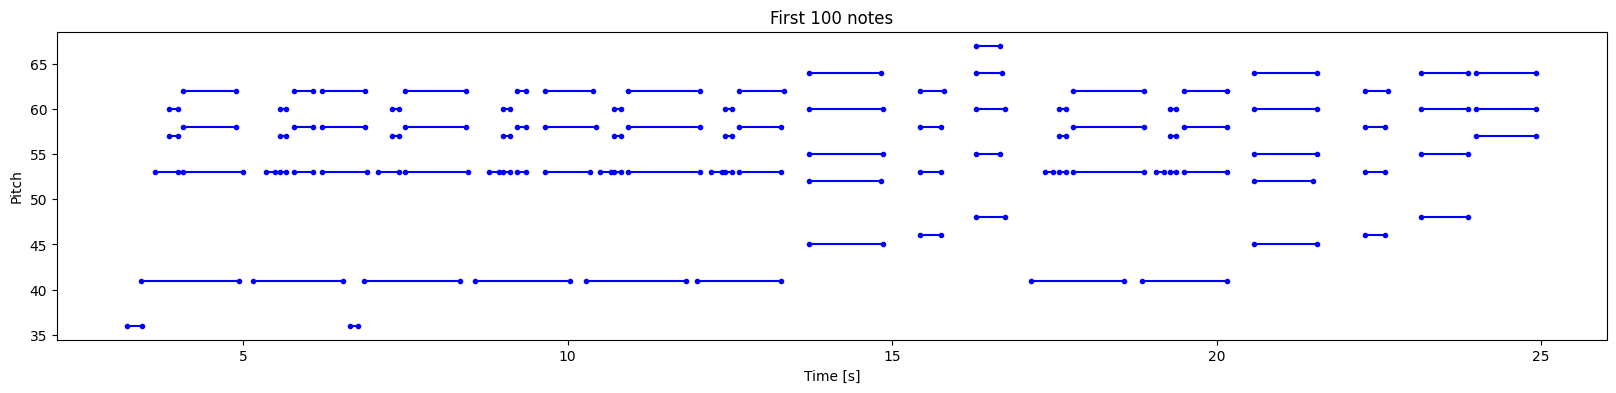

In [25]:
plot_piano_roll(raw_notes, count=100)

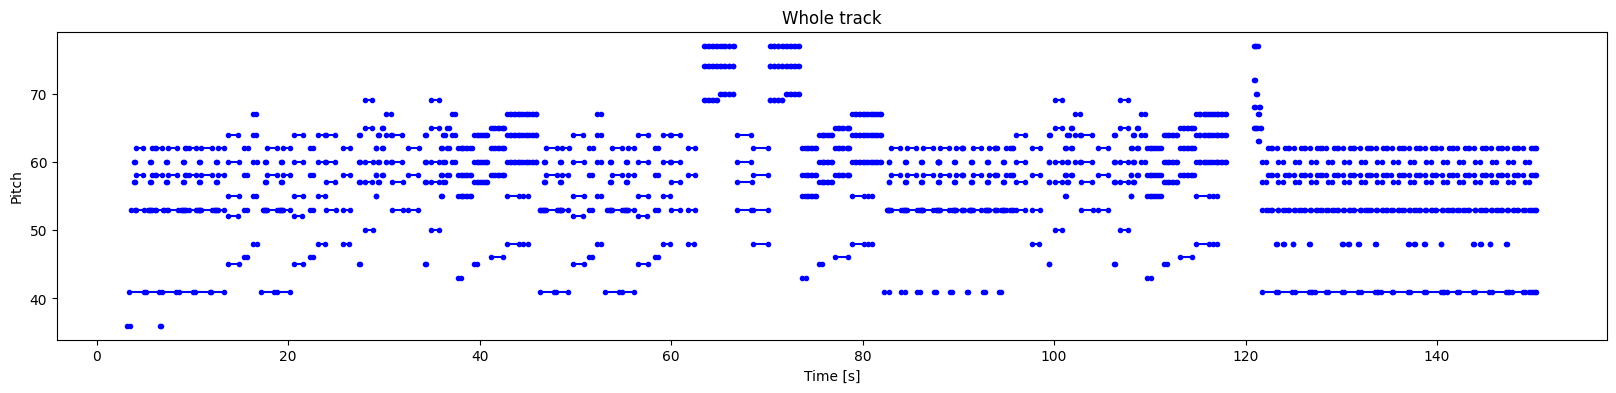

In [26]:
plot_piano_roll(raw_notes)

In [27]:
#function to plot the histogram  ditrubutions of pitch, duration and step
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

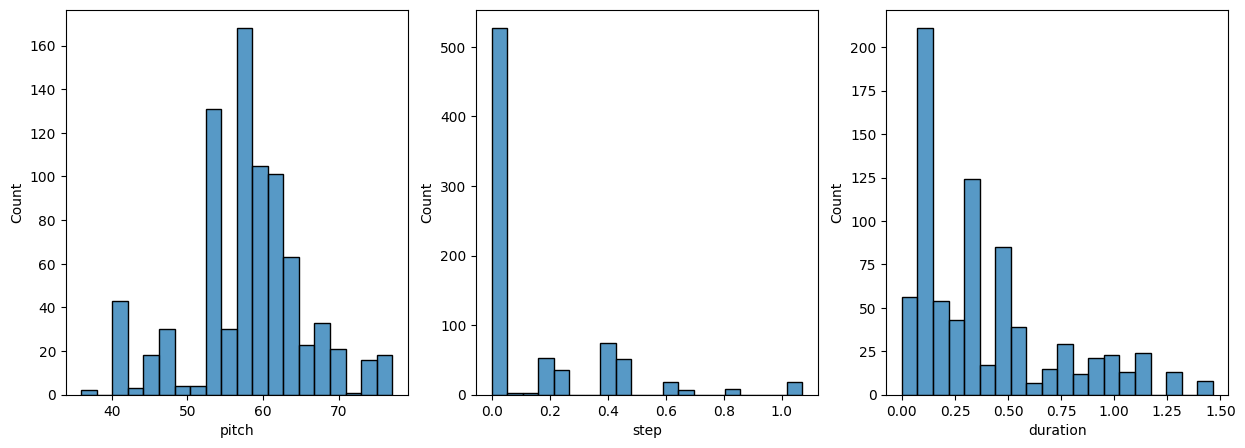

In [28]:
plot_distributions(raw_notes)

#Data Cleaning
converting the previous data into usable data using the pretty midi library to convert files into a trainable format, also dropping values that have corruptions or errors.

In [75]:
num_files = 500
all_notes = []
for f in paths[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

Error processing file Midi/Crow_Sheryl/Tomorrow_Never_Dies.mid: data byte must be in range 0..127


/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI

Error processing file Midi/The_Offspring/No_Hero.mid: MThd not found. Probably not a MIDI file
Error processing file Midi/The_Offspring/Gone_Away.1.mid: MIDI file has a largest tick of 196929468, it is likely corrupt


/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI

Error processing file Midi/Supertramp/Bloody_Well_Right.mid: data byte must be in range 0..127
Error processing file Midi/Supertramp/The_Logical_Song.7.mid: 


/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI

Error processing file Midi/The_Rolling_Stones/The_Last_Time.mid: 


/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI

Error processing file Midi/Bruce_Springsteen/Tenth_Avenue_Freeze-Out.1.mid: MIDI file has a largest tick of 33639950, it is likely corrupt


/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Error processing file Midi/Robert_Palmer/Mercy_Mercy_Me_I_Want_You.mid: data byte must be in range 0..127
Error processing file Midi/Robert_Palmer/Ill_Be_Your_Baby_Tonight.1.mid: data byte must be in range 0..127


/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Error processing file Midi/Phish/Taste.mid: MThd not found. Probably not a MIDI file


In [97]:
df = all_notes.dropna()
df

,pitch,start,end,step,duration
0,69,2.448976,6.721929,0.000000,4.272953
1,57,2.448976,6.728306,0.000000,4.279330
0,65,9.534878,10.077513,0.000000,0.542635
1,57,9.534878,10.077513,0.000000,0.542635
2,62,9.534878,10.077513,0.000000,0.542635
...,...,...,...,...,...
367,55,237.064944,237.281110,0.449248,0.216165
368,50,237.291448,237.742576,0.226504,0.451128
369,55,237.743516,238.172088,0.452068,0.428572
370,55,238.189005,238.424907,0.445489,0.235902


In [96]:
n_notes = len(df)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 472241


seperating the features to be trained on

In [95]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([df[key] for key in key_order], axis=1)

In [94]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [81]:
# function to split the given dataset into  equal sequences for better training performance, also dropping any incomplete sequences
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size : int,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x;

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [108]:
seq_length = 50
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(50, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [107]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (50, 3)
sequence elements (first 10): tf.Tensor(
[[0.5390625  0.         4.27295292]
 [0.4453125  0.         4.27933046]
 [0.5078125  0.         0.54263533]
 [0.4453125  0.         0.54263533]
 [0.484375   0.         0.54263533]
 [0.5078125  0.697674   0.2906975 ]
 [0.4453125  0.         0.2906975 ]
 [0.484375   0.         0.2906975 ]
 [0.5078125  0.465116   0.232558  ]
 [0.4453125  0.         0.232558  ]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=67.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=1.1627899999999975>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.7751933333333341>}


Creating the training data

In [106]:
batch_size = 128
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [105]:
train_ds.element_spec

(TensorSpec(shape=(128, 50, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(128,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(128,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(128,), dtype=tf.float64, name=None)})

Defining a custom loss function to measure loss

In [104]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

Defining and compiling the model

In [115]:
input_shape = (seq_length, 3)
learning_rate = 0.001

inputs = keras.Input(input_shape)
x_in = Sequential([
    (LSTM(128, activation='relu')),
])
x = x_in(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 50, 3)]              0         []                            
                                                                                                  
 sequential_9 (Sequential)   (None, 128)                  67584     ['input_10[0][0]']            
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['sequential_9[0][0]']        
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['sequential_9[0][0]']        
                                                                                            

In [116]:
losses = model.evaluate(train_ds, return_dict=True)
losses

3688/3688 [==============================] - 243s 66ms/step - loss: 6.9337 - duration_loss: 0.4558 - pitch_loss: 4.8453 - step_loss: 1.6325


{'loss': 6.933689594268799,
 'duration_loss': 0.45582467317581177,
 'pitch_loss': 4.8453497886657715,
 'step_loss': 1.6325013637542725}

reduce any inconsistencies in loss, by tuning loss weights below

In [117]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.03,
        'step': 0.5,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [118]:
model.evaluate(train_ds, return_dict=True)

3688/3688 [==============================] - 237s 64ms/step - loss: 1.4174 - duration_loss: 0.4558 - pitch_loss: 4.8453 - step_loss: 1.6325


{'loss': 1.4174349308013916,
 'duration_loss': 0.45582467317581177,
 'pitch_loss': 4.8453497886657715,
 'step_loss': 1.6325013637542725}

In [119]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [120]:
%%time
epochs = 15

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks =callbacks
)

Epoch 1/15
3688/3688 [==============================] - 560s 151ms/step - loss: 77.0491 - duration_loss: 68.5801 - pitch_loss: 3.8362 - step_loss: 16.7079
Epoch 2/15
3688/3688 [==============================] - 562s 152ms/step - loss: 0.6885 - duration_loss: 0.1028 - pitch_loss: 3.5223 - step_loss: 0.9602
Epoch 3/15
3688/3688 [==============================] - 547s 148ms/step - loss: 0.6705 - duration_loss: 0.0967 - pitch_loss: 3.3192 - step_loss: 0.9485
Epoch 4/15
3688/3688 [==============================] - 529s 144ms/step - loss: 0.6585 - duration_loss: 0.0936 - pitch_loss: 3.1429 - step_loss: 0.9412
Epoch 5/15
3688/3688 [==============================] - 545s 148ms/step - loss: 0.6556 - duration_loss: 0.0931 - pitch_loss: 3.1327 - step_loss: 0.9372
Epoch 6/15
3688/3688 [==============================] - 552s 150ms/step - loss: 0.6509 - duration_loss: 0.0927 - pitch_loss: 3.0811 - step_loss: 0.9315
Epoch 7/15
3688/3688 [==============================] - 533s 145ms/step - loss: 0.644

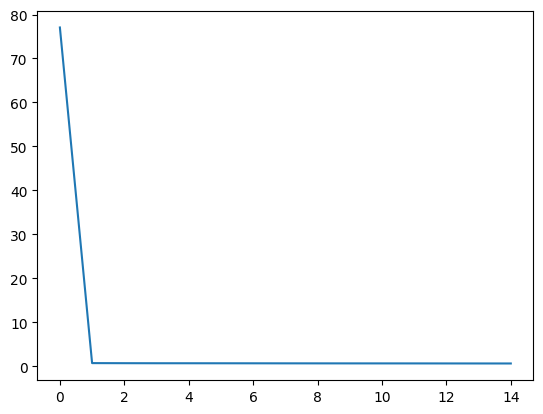

In [121]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [122]:
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [ ]:
temperature = 1.0
num_predictions = 1200

sample_notes = np.stack([df[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

In [124]:
generated_notes.tail(10)

,pitch,step,duration,start,end
1190,42,66.149368,0.000000,131288.671169,131288.671169
1191,69,22.910276,13.546711,131311.581445,131325.128156
1192,74,28.650846,19.226559,131340.232291,131359.458850
1193,74,38.573063,59.150269,131378.805354,131437.955623
1194,74,247.441635,303.157379,131626.246990,131929.404369
1195,84,0.000000,1017.506042,131626.246990,132643.753032
1196,85,0.000000,1481.456421,131626.246990,133107.703410
1197,85,0.000000,2885.646973,131626.246990,134511.893962
1198,82,0.000000,816.953308,131626.246990,132443.200298
1199,33,663.798889,1496.584351,132290.045879,133786.630229


In [125]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

In [ ]:
plot_piano_roll(generated_notes)

In [ ]:
plot_distributions(generated_notes)

In [ ]:
files.download(out_file)